Build a network of simple LIF neurons, say, 1,000 total, consisting of populations of Excitatory and PV, SST, and VIP inhibitory neurons. No need to model separate layers. You can check our paper for realistic fractions of these different populations (see, e.g., Fig. 1).

Connect the neurons with probabilities that can be taken from the same paper as above. See Fig. 4A. You can use the probabilities for E, PV, SST, and VIP (Htr3a) neurons in Layer 2/3.

Provide some spiking input to your network model – you can follow what is done in the tutorial above. The point is that there should be an external stimulus activating the network, and we should see spiking activity as a result of that.

Tune your network to respond to these stimuli reasonably well, meaning that the network activity is not exploding and exhibits realistic firing rates (check V1 firing rates in the Neuron paper, e.g., in Fig. 7B).

If this works, try perturbations – shut down each population one by one (excitatory, PV, SST, VIP). What effect does that have on the activity?

In [1]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.bionet import rand_syn_locations
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.create_environment import create_environment
from bmtk.analyzer.spike_trains import plot_raster
from bmtk.analyzer.compartment import plot_traces

In [2]:
for f in glob.glob('network/*'):
    try:
        os.remove(f)
    except FileNotFoundError as fnfe:
        pass

In [3]:
V1 = NetworkBuilder('V1')
num_e1_Scann1a = 300
num_e2_Rorb = 300
num_e3_Nr5a1 = 251
num_i1_Pvalb = 64
num_i2_Sst = 52
num_i3_Htr3a = 33
shared_max_syns_scalar = 1
max_exc2exc_synapses = round(15*shared_max_syns_scalar)
max_exc2inh_synapses = round(24*shared_max_syns_scalar)
max_inh2inh_synapses = round(15*shared_max_syns_scalar)
max_inh2exc_synapses = round(15*shared_max_syns_scalar)
shared_weight_scalar = 2
exc2exc_weight_scalar = 1*shared_weight_scalar 
inh2inh_weight_scalar = 2*shared_weight_scalar # 1
exc2inh_weight_scalar = 4*shared_weight_scalar # 2
inh2exc_weight_scalar = 1*shared_weight_scalar
noise_syn_weight = 1.0e-07

In [4]:
np.random.seed(100)

In [5]:
import numpy as np


def get_coords_column(N, radius_min=0.0, radius_max=400.0):
    phi = 2.0 * np.pi * np.random.random([N])
    r = np.sqrt((radius_min**2 - radius_max**2) * np.random.random([N]) + radius_max**2)
    x = r * np.cos(phi)
    y = np.random.uniform(400.0, 500.0, size=N)
    z = r * np.sin(phi)
    return x, y, z


def get_coords_plane(ncells, size_x=240.0, size_y=120.0):
    xs = np.random.uniform(0.0, size_x, ncells)
    ys = np.random.uniform(0.0, size_y, ncells)
    return xs, ys


def exc_exc_rule(source, target, max_syns):
    """Connect rule for exc-->exc neurons, should return an integer 0 or greater. The number of 
    connections will be weighted according to the difference between source and target cells' 
    tuning_angle property"""
    if source['node_id'] == target['node_id']:
        # prevent a cell from synapsing with itself
        return 0
    
    # calculate the distance between tuning angles and use it to choose
    # number of connections using a binomial distribution.
    src_tuning = source['tuning_angle']
    trg_tuning = target['tuning_angle']
    tuning_dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    probs = 1.0 - (np.max((tuning_dist, 10.0)) / 180.0)
    return np.random.binomial(n=max_syns, p=probs)

def others_conn_rule(source, target, max_syns, prob=None, max_distance=300.0, sigma=60.0):
    """Connection rule for exc-->inh, inh-->exc, or inh-->inh connections. The number of connections
    will be based on the euclidian distance between source and target cell.
    """
    if source['node_id'] == target['node_id']:
        return 0
    
    if prob is None:
        dist = np.sqrt((source['x'] - target['x'])**2 + (source['z'] - target['z'])**2)
        if dist > max_distance:
            return 0
        prob = np.exp(-(dist/sigma)**2)
        
    return np.random.binomial(n=max_syns, p=prob)

def like2like_weight(source, target, min_weight, max_weight, noise_weight, signal_type = None):
    src_tuning = source['tuning_angle']
    trg_tuning = target['tuning_angle']
    tuning_dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    probs = 1.0 - (np.max((tuning_dist, 10.0)) / 180.0)
    if signal_type == None:
        conn_sign = 1
    elif signal_type == 'exc':
        conn_sign = 1
    elif signal_type == 'inh':
        conn_sign = -1
        
    return conn_sign*(np.max([max_weight*probs, min_weight])+np.random.uniform(0, noise_weight))

In [6]:
from bmtk.builder.networks import NetworkBuilder

x, y, z = get_coords_column(num_e1_Scann1a)
V1.add_nodes(
    N=num_e1_Scann1a,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',   
    x=x, y=y, z=z,
    model_name='Scnn1a',
    ei_type='e',
    tuning_angle=np.random.uniform(0.0, 360.0, size=num_e1_Scann1a)
)

x, y, z = get_coords_column(num_e2_Rorb)
V1.add_nodes(
    N=num_e2_Rorb,
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Rorb_512332555_glif_lif_asc.json',
    x=x, y=y, z=z,   
    model_name='Rorb', 
    ei_type='e',
    tuning_angle=np.random.uniform(0.0, 360.0, size=num_e2_Rorb)
)

x, y, z = get_coords_column(num_e3_Nr5a1)
V1.add_nodes(
    N=num_e3_Nr5a1,
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Nr5a1_587862586_glif_lif_asc.json',   
    x=x, y=y, z=z,    
    model_name='Nr5a1', 
    ei_type='e',
    tuning_angle=np.random.uniform(0.0, 360.0, size=num_e3_Nr5a1)
)

x, y, z = get_coords_column(num_i1_Pvalb)
V1.add_nodes(
    N=num_i1_Pvalb,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Pvalb_574058595_glif_lif_asc.json',
    x=x, y=y, z=z, 
    model_name='PValb',
    ei_type='i',
    tuning_angle=np.random.uniform(0.0, 360.0, size=num_i1_Pvalb)
)

x, y, z = get_coords_column(num_i2_Sst)
V1.add_nodes(
    N=num_i2_Sst,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Sst_501282204_glif_lif_asc_config.json',
    x=x, y=y, z=z, 
    model_name='Sst',
    ei_type='i',
    tuning_angle=np.random.uniform(0.0, 360.0, size=num_i2_Sst),
)

x, y, z = get_coords_column(num_i3_Htr3a)
V1.add_nodes(
    N=num_i3_Htr3a,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Htr3a_474626527_glif_lif_asc_config.json',
    x=x, y=y, z=z, 
    model_name='Htr3a',
    ei_type='i',
    tuning_angle=np.random.uniform(0.0, 360.0, size=num_i3_Htr3a),
)

In [7]:
# Add recurrent edges
# (1) e to e
conn = V1.add_edges(
    source=V1.nodes(ei_type='e'),
    target=V1.nodes(ei_type='e'),    
    connection_rule=exc_exc_rule,
    connection_params={'max_syns': max_exc2exc_synapses},
    delay=1.6,
    dynamics_params='static_ExcToExc.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.36*exc2exc_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'exc'},
                    dtypes=np.float)
# (2.1) e to Pvalb
conn = V1.add_edges(
    source=V1.nodes(ei_type='e'),
    target=V1.nodes(model_name='PValb'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_exc2inh_synapses, 'prob': 0.395},
    delay=1.2,
    dynamics_params='static_ExcToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 1.49*exc2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'exc'},
                    dtypes=np.float)
# (2.2) Pvalb to e
conn = V1.add_edges(
    source=V1.nodes(model_name='PValb'),
    target=V1.nodes(ei_type='e'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2exc_synapses, 'prob': 0.411},
    delay=0.9,
    dynamics_params='static_InhToExc.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.48*inh2exc_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (3.1) e to Sst
conn = V1.add_edges(
    source=V1.nodes(ei_type='e'),
    target=V1.nodes(model_name='Sst'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_exc2inh_synapses*2, 'prob': 0.182},
    delay=1.5,
    dynamics_params='static_ExcToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.86*exc2inh_weight_scalar*2,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'exc'},
                    dtypes=np.float)
# (3.2) Sst to e
conn = V1.add_edges(
    source=V1.nodes(model_name='Sst'),
    target=V1.nodes(ei_type='e'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2exc_synapses, 'prob': 0.424},
    delay=1.5,
    dynamics_params='static_InhToExc.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.31*inh2exc_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (4.1) e to Htr3a
conn = V1.add_edges(
    source=V1.nodes(ei_type='e'),
    target=V1.nodes(model_name='Htr3a'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_exc2inh_synapses, 'prob': 0.105},
    delay=1.5,
    dynamics_params='static_ExcToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 1.31*exc2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'exc'},
                    dtypes=np.float)
# (4.2) Htr3a to e
conn = V1.add_edges(
    source=V1.nodes(model_name='Htr3a'),
    target=V1.nodes(ei_type='e'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2exc_synapses, 'prob': 0.087},
    delay=1.5,
    dynamics_params='static_InhToExc.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.28*inh2exc_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)

# (5) Pvalb to Pvalb
conn = V1.add_edges(
    source=V1.nodes(model_name='Pvalb'),
    target=V1.nodes(model_name='Pvalb'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.451},
    delay=1.6,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.68*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)

# (6.1) Pvalb to Sst
conn = V1.add_edges(
    source=V1.nodes(model_name='Pvalb'),
    target=V1.nodes(model_name='Sst'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.03},
    delay=1.2,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.42*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (6.2) Sst to Pvalb
conn = V1.add_edges(
    source=V1.nodes(model_name='Sst'),
    target=V1.nodes(model_name='Pvalb'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.857},
    delay=1.5,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.5*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (7.1) Pvalb to Htr3a
conn = V1.add_edges(
    source=V1.nodes(model_name='Pvalb'),
    target=V1.nodes(model_name='Htr3a'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.22},
    delay=1.2,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.41*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (7.2) Htr3a to Pvalb
conn = V1.add_edges(
    source=V1.nodes(model_name='Htr3a'),
    target=V1.nodes(model_name='Pvalb'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.02},
    delay=1.5,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.18*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (8) Sst to Sst
conn = V1.add_edges(
    source=V1.nodes(model_name='Sst'),
    target=V1.nodes(model_name='Sst'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.082},
    delay=1.5,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.15*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (9.1) Sst to Htr3a
conn = V1.add_edges(
    source=V1.nodes(model_name='Sst'),
    target=V1.nodes(model_name='Htr3a'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.77},
    delay=1.5,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.52*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (9.2) Htr3a to Sst
conn = V1.add_edges(
    source=V1.nodes(model_name='Htr3a'),
    target=V1.nodes(model_name='Sst'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.625},
    delay=1.5,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.32*inh2inh_weight_scalar*0.1,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)
# (10) Htr3a to Htr3a
conn = V1.add_edges(
    source=V1.nodes(model_name='Htr3a'),
    target=V1.nodes(model_name='Htr3a'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': max_inh2inh_synapses, 'prob': 0.028},
    delay=1.5,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)
conn.add_properties('syn_weight',
                    rule=like2like_weight,
                    rule_params={'min_weight': 1.0e-06, 'max_weight': 0.37*inh2inh_weight_scalar,
                                 'noise_weight': noise_syn_weight, 'signal_type': 'inh'},
                    dtypes=np.float)

/tmp/ipykernel_28/2057661607.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtypes=np.float)
/tmp/ipykernel_28/2057661607.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtypes=np.float)
/tmp/ipykernel_28/2057661607.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use

In [8]:
V1.build()
V1.save(output_dir='network')

In [9]:
def connect_lgn_cells(source, targets, max_targets, min_syns=1, max_syns=15, lgn_size=(240, 120),
                      V1_radius=400.0, ellipse=(100.0, 500.0)):
    # map the lgn cells from the plane to the circle
    x, y = source['x'], source['y']
    x = 2*(x / lgn_size[0] - 0.5)
    y = 2*(y / lgn_size[1] - 0.5)
    src_x = x * np.sqrt(1.0 - (y**2/2.0)) * V1_radius
    src_y = y * np.sqrt(1.0 - (x**2/2.0)) * V1_radius
    
    # Find (the indices) of all the target cells that are within the given ellipse, if there are more than max_targets
    # then randomly choose them
    a, b = ellipse[0]**2, ellipse[1]**2
    dists = [(src_x-t['x'])**2/a + (src_y-t['y'])**2/b for t in targets]
    valid_targets = np.argwhere(np.array(dists) <= 1.0).flatten()
    if len(valid_targets) > max_targets:
        valid_targets = np.random.choice(valid_targets, size=max_targets, replace=False)

    # create an array of all synapse counts. Most targets will have 0 connection, except for the "valid_targets" which
    # which will have between [min_syns, max_syns] number of connections.
    nsyns_arr = np.zeros(len(targets), dtype=int)
    for idx in valid_targets:
        nsyns_arr[idx] = np.random.randint(min_syns, max_syns)

    return nsyns_arr

In [10]:
lgn = NetworkBuilder('lgn')

# Build Nodes
x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tON_TF8',
    dynamics_params='tON_TF8.json',
    ei_type='e'
)

x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tOFF_TF8',
    dynamics_params='tOFF_TF8.json',
    ei_type='e'
)

x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:sON_TF8',
    dynamics_params='sON_TF8.json',
    ei_type='e'
)

x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:sOFF_TF15',
    dynamics_params='sOFF_TF15.json',
    ei_type='e'
)

# Build Edges
lgn.add_edges(
    source=lgn.nodes(),
    target=V1.nodes(ei_type='e'),
    connection_rule = connect_lgn_cells,
    connection_params = {'max_targets': 6},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToExc.json',
    delay=2.0,
    syn_weight=15.0  # 11.0
)

lgn.add_edges(
    source=lgn.nodes(),
    target=V1.nodes(model_name='Pvalb'),
    connection_rule=connect_lgn_cells,
    connection_params={'max_targets': 12, 'ellipse': (400.0, 400.0)},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToInh.json',
    delay=2.0,
    syn_weight=13.0  # 13.0
)

lgn.add_edges(
    source=lgn.nodes(),
    target=V1.nodes(model_name='Sst'),
    connection_rule=connect_lgn_cells,
    connection_params={'max_targets': 6, 'ellipse': (400.0, 400.0)},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToInh.json',
    delay=2.0,
    syn_weight= 5.0  # 13.0
)

lgn.add_edges(
    source=lgn.nodes(),
    target=V1.nodes(model_name='Htr3a'),
    connection_rule=connect_lgn_cells,
    connection_params={'max_targets': 6, 'ellipse': (400.0, 400.0)},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToInh.json',
    delay=2.0,
    syn_weight=5.0  # 13.0
)


In [11]:
lgn.build()
lgn.save(output_dir='network')

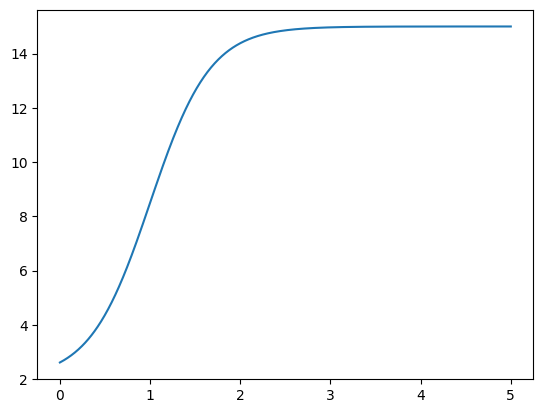

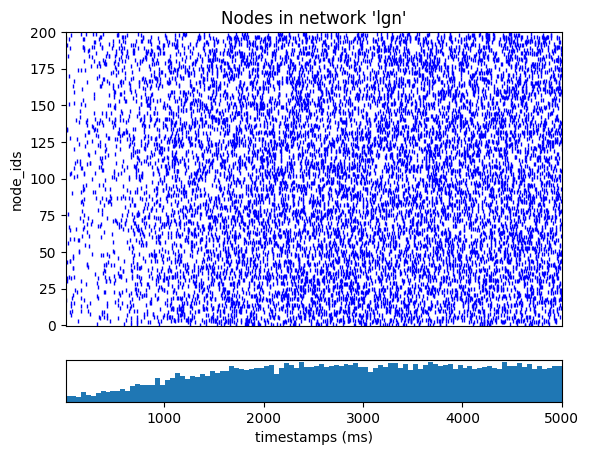

In [12]:
import matplotlib.pyplot as plt

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.analyzer.spike_trains import plot_raster

times = np.linspace(0.0, 5.0, 1000)
max_rate = 15.0
min_rate = 2.0
onset = 1.0
rates = (max_rate-min_rate)/(1.0 + np.exp(-(times-onset)*3.0)) + min_rate

psg = PoissonSpikeGenerator()
psg.add(
    node_ids='network/lgn_nodes.h5', 
    firing_rate=rates, 
    times=times,
    population='lgn'
)
psg.to_sonata('inputs/lgn_spikes.h5')

# plot the firing rates
plt.plot(times, rates)

_ = plot_raster(spikes_file='inputs/lgn_spikes.h5')

1.0 V1 responses to Ramp stimulation to LGN - Baseline 

In [13]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet_homework.json',
    network_dir='network',
    output_dir='output_pointnet_homework',
    tstop=3000.0, dt=0.1,
    report_vars=[('V1', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    run_script='run_pointnet_homework.py',
    overwrite=True,
)

In [14]:
import os
from distutils.dir_util import copy_tree

has_data_copied = True

if has_data_copied == False:
    os.makedirs('components/filter_models', exist_ok=True)
    copy_tree('../../../bmtk-workshop/Ch4_pointnet/components/filter_models', 'components/filter_models')
    os.makedirs('components/point_neuron_models', exist_ok=True)
    copy_tree('../../../bmtk-workshop/Ch4_pointnet/components/point_neuron_models', 'components/point_neuron_models')
    os.makedirs('components/synaptic_models', exist_ok=True)
    copy_tree('../../../bmtk-workshop/Ch4_pointnet/components/synaptic_models', 'components/synaptic_models')

In [15]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

numprocs=1

Apr 03 18:45:48 CopyFile [Error]: 
    Could not open source file.
Error in nest resource file: /BadIO in CopyFile_

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Mar 23 2022 13:33:37

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2024-04-03 18:45:48,952 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 18:45:48,995 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 18:45:49,013 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 18:45:49,204 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 18:45:49,205 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 18:45:49,239 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 18:45:52,966 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 18:45:53,112 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 18:45:53,350 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 18:47:02,886 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 18:47:18,069 [INFO] Done.


INFO:NestIOUtils:Done.


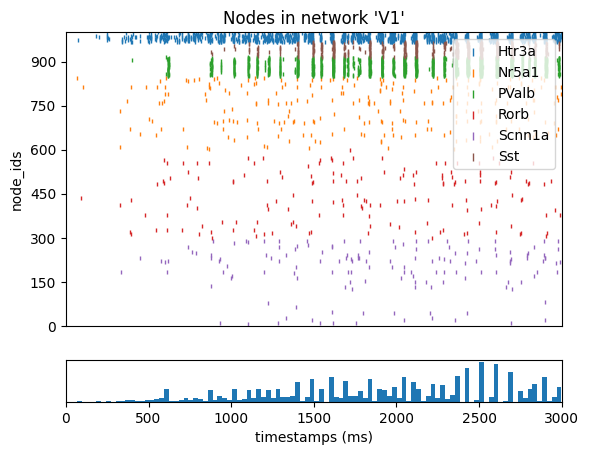

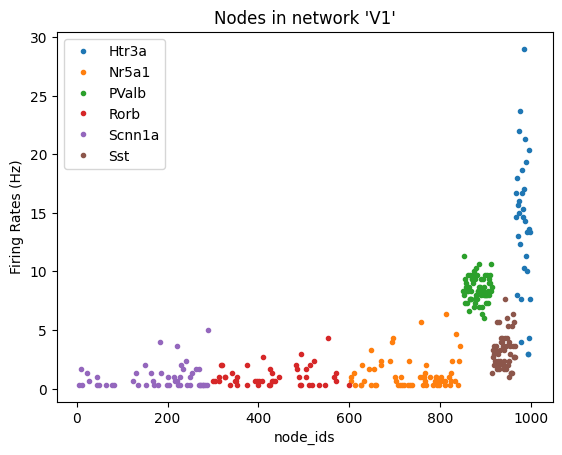

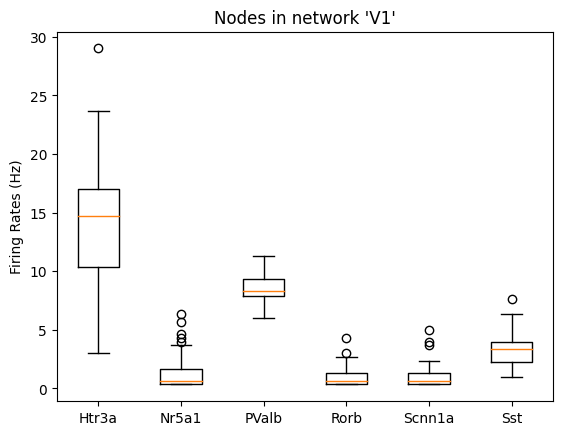

In [16]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates, plot_rates_boxplot

_ = plot_raster(config_file='config.pointnet_homework.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework.json', group_by='model_name')

In [17]:
import pandas as pd
pd.read_csv('./network/lgn_V1_edge_types.csv', sep=' ')

,edge_type_id,target_query,source_query,dynamics_params,delay,model_template,syn_weight
0,100,ei_type=='e',*,static_ExcToExc.json,2.0,static_synapse,15.0
1,101,model_name=='Pvalb',*,static_ExcToInh.json,2.0,static_synapse,13.0
2,102,model_name=='Sst',*,static_ExcToInh.json,2.0,static_synapse,5.0
3,103,model_name=='Htr3a',*,static_ExcToInh.json,2.0,static_synapse,5.0


In [18]:
pd.read_csv('./network/V1_V1_edge_types.csv', sep=' ')

,edge_type_id,target_query,source_query,dynamics_params,delay,model_template
0,100,ei_type=='e',ei_type=='e',static_ExcToExc.json,1.6,static_synapse
1,101,model_name=='PValb',ei_type=='e',static_ExcToInh.json,1.2,static_synapse
2,102,ei_type=='e',model_name=='PValb',static_InhToExc.json,0.9,static_synapse
3,103,model_name=='Sst',ei_type=='e',static_ExcToInh.json,1.5,static_synapse
4,104,ei_type=='e',model_name=='Sst',static_InhToExc.json,1.5,static_synapse
5,105,model_name=='Htr3a',ei_type=='e',static_ExcToInh.json,1.5,static_synapse
6,106,ei_type=='e',model_name=='Htr3a',static_InhToExc.json,1.5,static_synapse
7,107,model_name=='Pvalb',model_name=='Pvalb',static_InhToInh.json,1.6,static_synapse
8,108,model_name=='Sst',model_name=='Pvalb',static_InhToInh.json,1.2,static_synapse
9,109,model_name=='Pvalb',model_name=='Sst',static_InhToInh.json,1.5,static_synapse


1.1 Silence excitatory neurons

In [19]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet_homework_perturbation_exc.json',
    network_dir='network',
    output_dir='output_pointnet_homework_perturbation_exc',
    tstop=3000.0, dt=0.1,
    report_vars=[('V1', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    run_script='run_pointnet_homework_perturbation_exc.py',
    overwrite=True,
)

In [ ]:
'''
Modify the corresponding json file

"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/lgn_spikes.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "e"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [20]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_perturbation_exc.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 18:50:26,318 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 18:50:26,341 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 18:50:26,361 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 18:50:26,557 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 18:50:26,559 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 18:50:26,586 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 18:50:30,067 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 18:50:30,401 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 18:50:30,627 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 18:51:45,481 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 18:52:00,362 [INFO] Done.


INFO:NestIOUtils:Done.


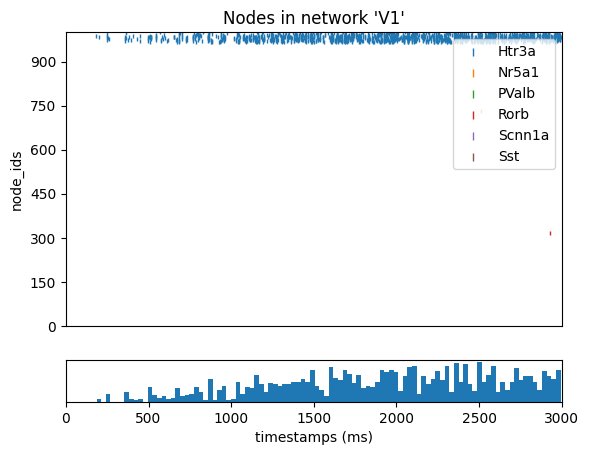

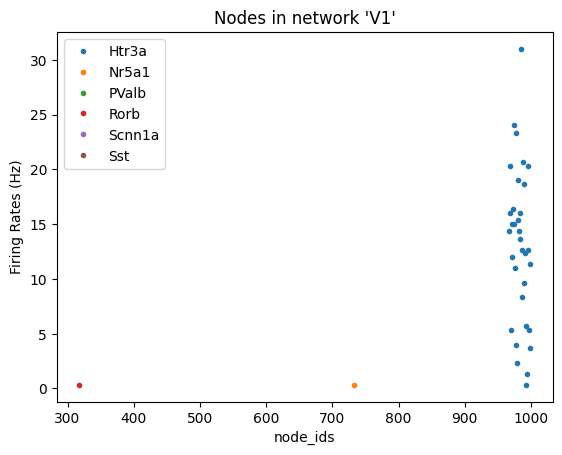

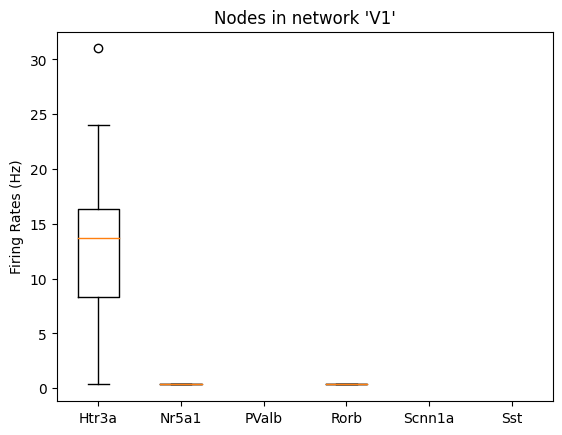

In [21]:
_ = plot_raster(config_file='config.pointnet_homework_perturbation_exc.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_perturbation_exc.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_perturbation_exc.json', group_by='model_name')

1.2 Silence PV neurons

In [22]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet_homework_perturbation_PV.json',
    network_dir='network',
    output_dir='output_pointnet_homework_perturbation_PV',
    tstop=3000.0, dt=0.1,
    report_vars=[('V1', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    run_script='run_pointnet_homework_perturbation_PV.py',
    overwrite=True,
)

In [ ]:
'''
Modify the corresponding json file

"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/lgn_spikes.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "i",
        "model_name": "PValb"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [23]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_perturbation_PV.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 18:54:00,132 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 18:54:00,152 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 18:54:00,173 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 18:54:00,382 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 18:54:00,385 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 18:54:00,414 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 18:54:03,802 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 18:54:03,988 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 18:54:04,220 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 18:56:48,627 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 18:57:03,250 [INFO] Done.


INFO:NestIOUtils:Done.


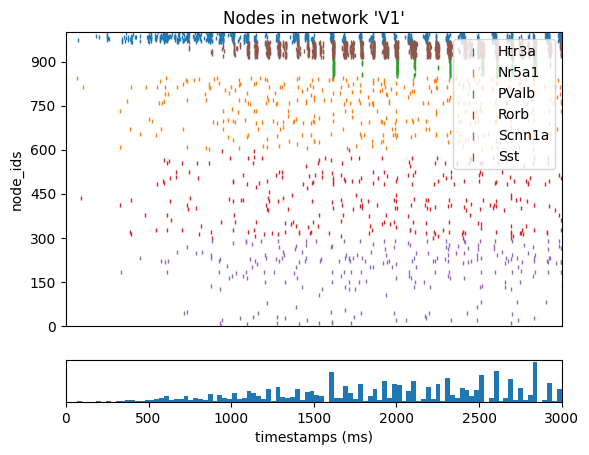

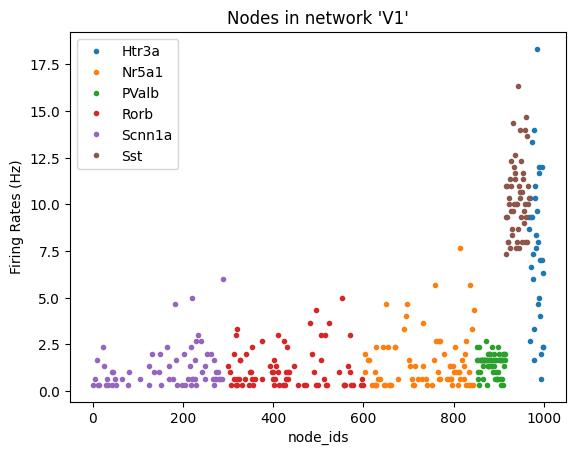

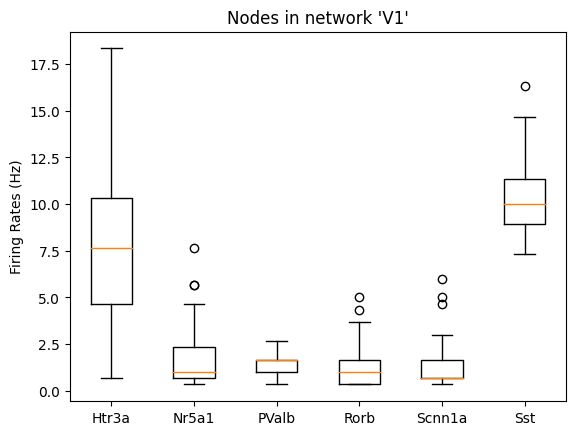

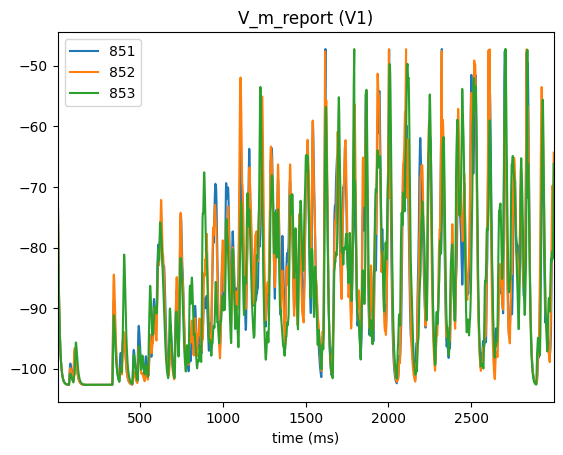

In [51]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates, plot_rates_boxplot

_ = plot_raster(config_file='config.pointnet_homework_perturbation_PV.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_perturbation_PV.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_perturbation_PV.json', group_by='model_name')

from bmtk.analyzer.compartment import plot_traces

# Plot the membrane potential trace
_ = plot_traces(config_file='config.pointnet_homework_perturbation_PV.json', node_ids = [851, 852, 853], report_name='V_m_report')

1.3 Silence SST neurons

In [25]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet_homework_perturbation_SST.json',
    network_dir='network',
    output_dir='output_pointnet_homework_perturbation_SST',
    tstop=3000.0, dt=0.1,
    report_vars=[('V1', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    run_script='run_pointnet_homework_perturbation_SST.py',
    overwrite=True,
)

In [ ]:
'''
Modify the corresponding json file

"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/lgn_spikes.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "i",
        "model_name": "Sst"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [26]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_perturbation_SST.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 19:00:55,001 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 19:00:55,020 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 19:00:55,039 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 19:00:55,303 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 19:00:55,305 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 19:00:55,337 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 19:00:58,881 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 19:00:59,066 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 19:00:59,298 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 19:02:11,749 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 19:02:27,367 [INFO] Done.


INFO:NestIOUtils:Done.


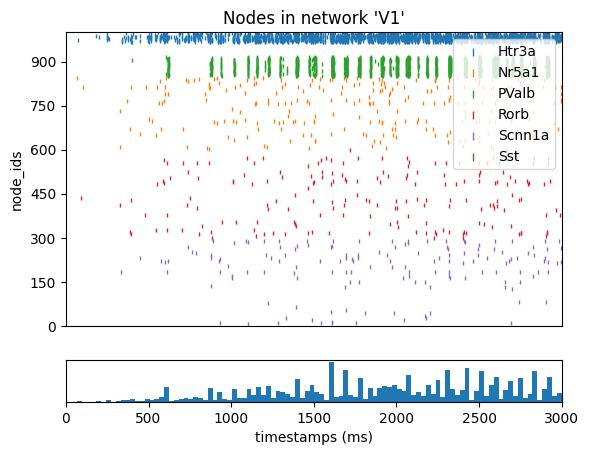

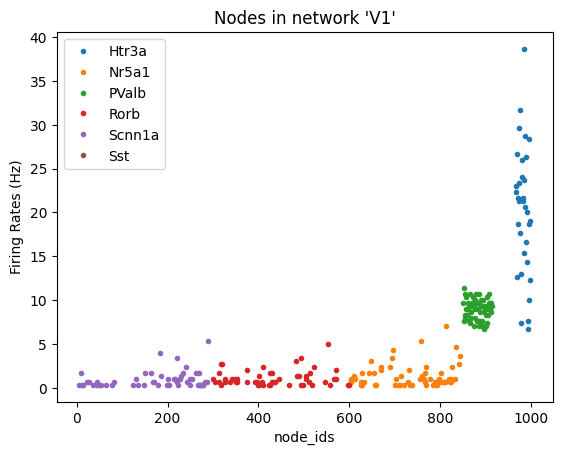

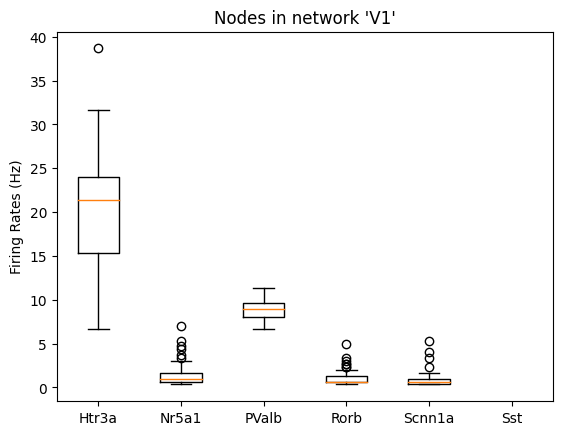

In [27]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates, plot_rates_boxplot

_ = plot_raster(config_file='config.pointnet_homework_perturbation_SST.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_perturbation_SST.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_perturbation_SST.json', group_by='model_name')

1.4 Silence VIP neurons

In [28]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet_homework_perturbation_VIP.json',
    network_dir='network',
    output_dir='output_pointnet_homework_perturbation_VIP',
    tstop=3000.0, dt=0.1,
    report_vars=[('V1', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    run_script='run_pointnet_homework_perturbation_VIP.py',
    overwrite=True,
)

In [ ]:
'''
Modify the corresponding json file

"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/lgn_spikes.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "i",
        "model_name": "Htr3a"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [29]:
configure = pointnet.Config.from_json('config.pointnet_homework_perturbation_VIP.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 19:06:50,280 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 19:06:50,308 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 19:06:50,329 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 19:06:50,580 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 19:06:50,583 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 19:06:50,613 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 19:06:54,179 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 19:06:54,361 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 19:06:54,593 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 19:08:07,243 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 19:08:22,610 [INFO] Done.


INFO:NestIOUtils:Done.


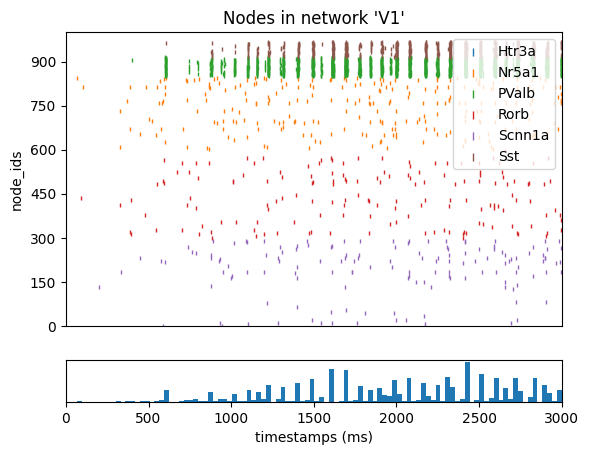

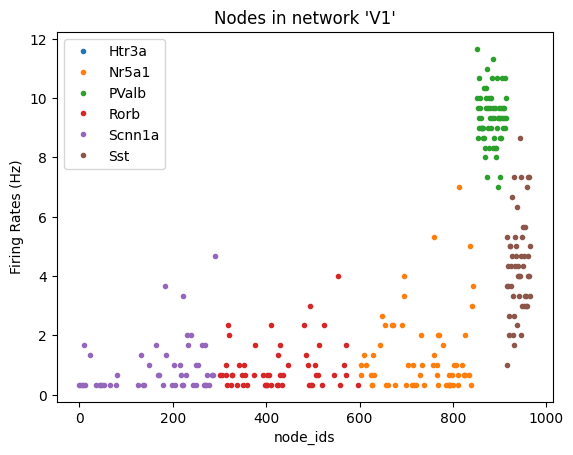

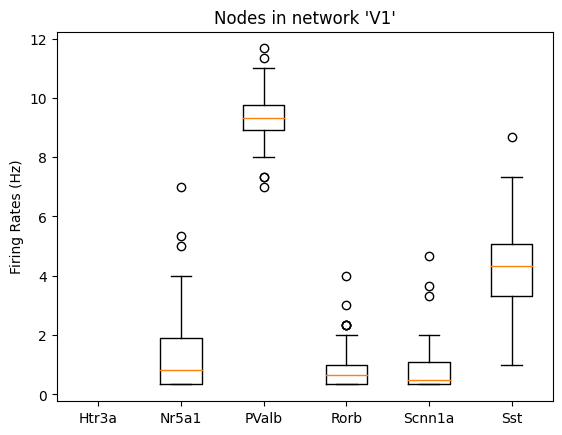

In [30]:
_ = plot_raster(config_file='config.pointnet_homework_perturbation_VIP.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_perturbation_VIP.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_perturbation_VIP.json', group_by='model_name')

2.0 V1 network responses to grating stimulus

In [31]:
from bmtk.utils.create_environment import create_environment
has_it_been_run = False

if has_it_been_run == False:
    create_environment(
        'filternet',
        base_dir='.',
        config_file='config.filternet_homework_grating.json',
        network_dir='network',
        network_filter='lgn_node',     # used to filter out only the lgn_nodes.h5 and lgn_node_types.csv file
        output_dir='inputs',
        tstop=3000.0, dt=0.1,
        overwrite=True
    )

In [ ]:
'''
Modify the json file

"inputs": {
    "LGN_spikes": {
      "input_type": "movie",
      "module": "graiting",
      "row_size": 240,
      "col_size": 240,
      "gray_screen_dur": 0.5,
      "cpd": 0.04,
      "temporal_f": 4.0,
      "contrast": 0.8,
      "theta": 45.0,
      "phase": 0.0,
      "frame_rate": 1000.0
    }
},

Change output to the input for V1

"output": {
    "log_file": "log.txt",
    "output_dir": "$OUTPUT_DIR",
    "spikes_file": "spikes.grating.h5",
    "rates_h5": "rates.grating.h5",
    "spikes_file_csv": "spikes.grating.csv"
  },

'''

In [32]:
from bmtk.simulator import filternet
configure = filternet.Config.from_json('config.filternet_homework_grating.json')
configure.build_env()

network = filternet.FilterNetwork.from_config(configure)
sim = filternet.FilterSimulator.from_config(configure, network)
sim.run()

2024-04-03 19:10:26,066 [WARNING] Directory /home/shared/workspace/Desktop/BrainSim/inputs already exists.


2024-04-03 19:10:26,069 [INFO] Created log file


INFO:FilterNetIOUtils:Created log file


2024-04-03 19:10:26,631 [INFO] Building cells.


INFO:FilterNetIOUtils:Building cells.


2024-04-03 19:10:30,500 [INFO] Evaluating rates.


INFO:FilterNetIOUtils:Evaluating rates.


2024-04-03 19:10:57,518 [INFO] Done.


INFO:FilterNetIOUtils:Done.


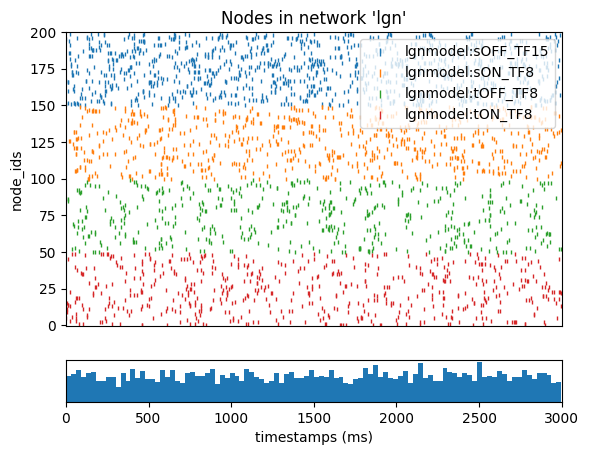

In [33]:
_ = plot_raster(config_file='config.filternet_homework_grating.json', group_by='model_template', show=False)

In [34]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet_homework_grating.json',
    network_dir='network',
    output_dir='output_pointnet_homework_grating',
    tstop=3000.0, dt=0.1,
    report_vars=[('V1', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/spikes.grating.h5')],
    run_script='run_pointnet_homework_grating.py',
    overwrite=True,
)    

In [35]:
configure = pointnet.Config.from_json('config.pointnet_homework_grating.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 19:13:23,778 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 19:13:23,802 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 19:13:23,823 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 19:13:24,013 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 19:13:24,016 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 19:13:24,049 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 19:13:27,459 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 19:13:27,567 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 19:13:27,801 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 19:14:37,226 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 19:14:51,797 [INFO] Done.


INFO:NestIOUtils:Done.


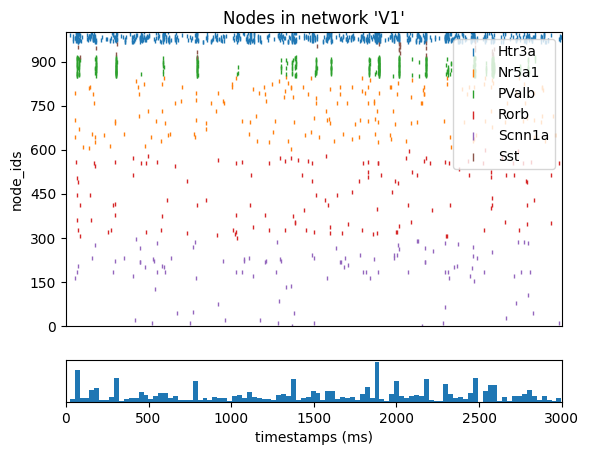

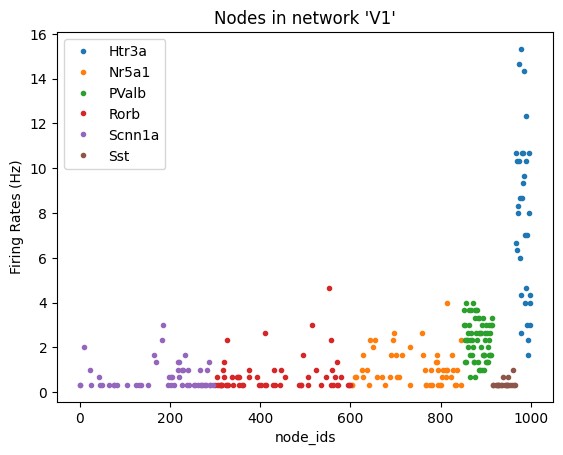

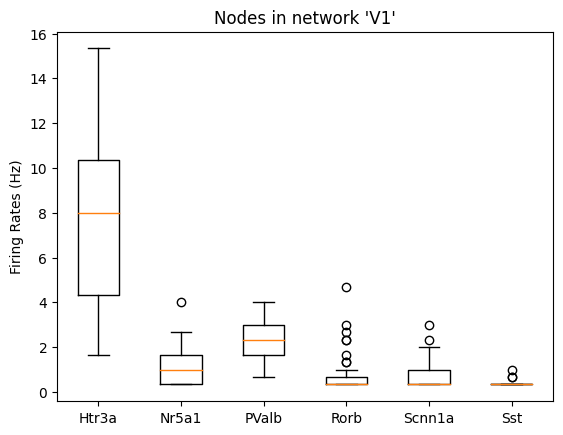

In [36]:
_ = plot_raster(config_file='config.pointnet_homework_grating.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_grating.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_grating.json', group_by='model_name')

2.1 silence excitatory neurons

In [37]:
# run only the first time
has_it_been_run = False
if has_it_been_run == False:
    create_environment(
        'pointnet',
        base_dir='.',
        config_file='config.pointnet_homework_grating_perturbation_exc.json',
        network_dir='network',
        output_dir='output_pointnet_homework_grating_perturbation_exc',
        tstop=3000.0, dt=0.1,
        report_vars=[('V1', 'V_m')],
        spikes_inputs=[('lgn', 'inputs/spikes.grating.h5')],
        run_script='run_pointnet_homework_grating_perturbation_exc.py',
        overwrite=True,
    )

In [ ]:
'''
Modify the corresponding json file

"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/spikes.grating.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "e"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
  
'''

In [38]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_grating_perturbation_exc.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 19:29:14,853 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 19:29:14,877 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 19:29:14,900 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 19:29:15,212 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 19:29:15,215 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 19:29:15,249 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 19:29:18,947 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 19:29:19,248 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 19:29:19,478 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 19:30:35,907 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 19:30:51,476 [INFO] Done.


INFO:NestIOUtils:Done.


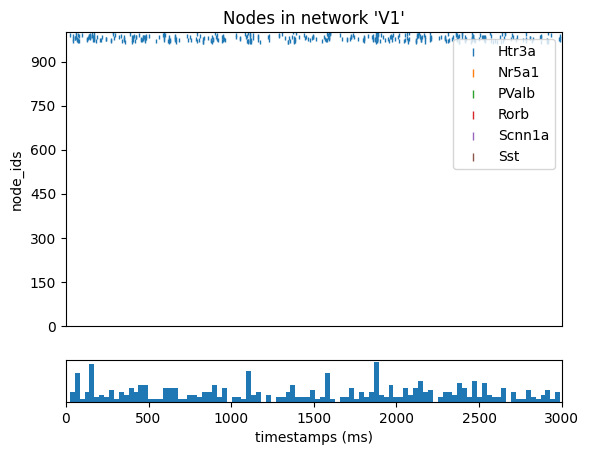

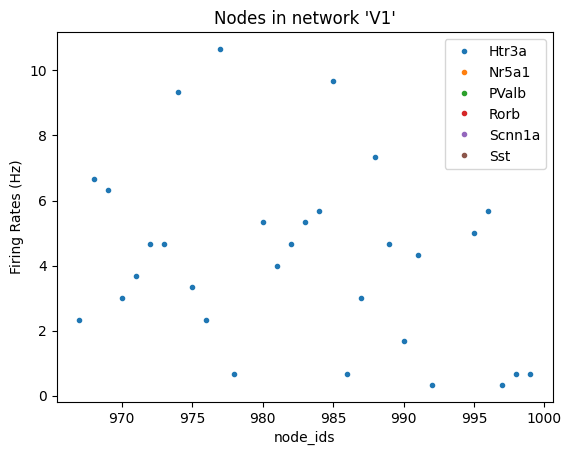

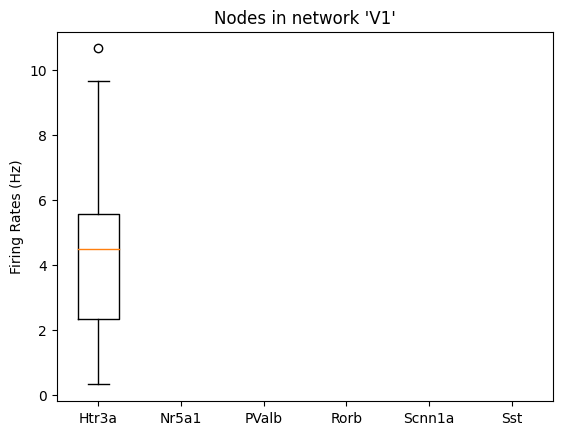

In [39]:
_ = plot_raster(config_file='config.pointnet_homework_grating_perturbation_exc.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_grating_perturbation_exc.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_grating_perturbation_exc.json', group_by='model_name')

2.2 Silence PV neurons

In [52]:
create_environment(
        'pointnet',
        base_dir='.',
        config_file='config.pointnet_homework_grating_perturbation_PV.json',
        network_dir='network',
        output_dir='output_pointnet_homework_grating_perturbation_PV',
        tstop=3000.0, dt=0.1,
        report_vars=[('V1', 'V_m')],
        spikes_inputs=[('lgn', 'inputs/spikes.grating.h5')],
        run_script='run_pointnet_homework_grating_perturbation_PV.py',
        overwrite=True,
    )

In [ ]:
'''
"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/spikes.grating.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "i",
        "model_name": "PValb"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [53]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_grating_perturbation_PV.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-04 14:18:55,547 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-04 14:18:55,593 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-04 14:18:55,613 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-04 14:18:55,968 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-04 14:18:55,972 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-04 14:18:56,008 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-04 14:19:00,009 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-04 14:19:00,169 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-04 14:19:00,394 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-04 14:20:13,406 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-04 14:20:30,743 [INFO] Done.


INFO:NestIOUtils:Done.


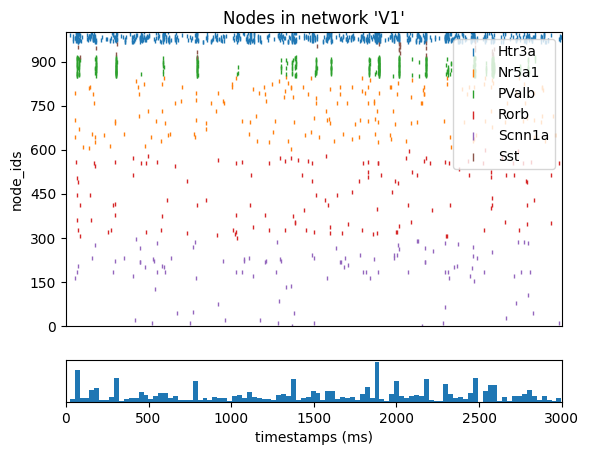

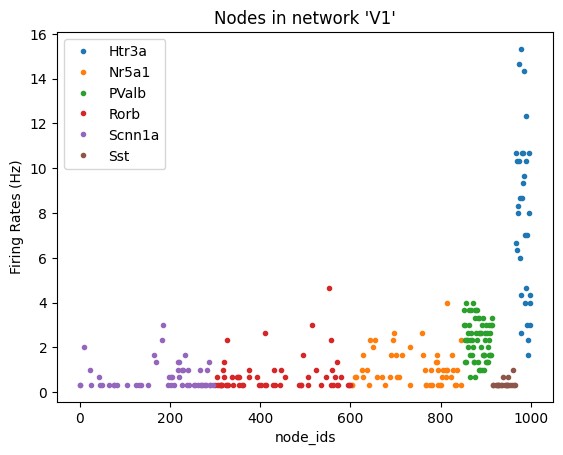

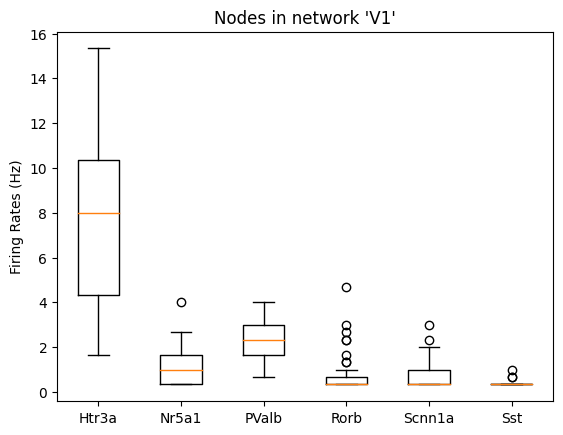

In [43]:
_ = plot_raster(config_file='config.pointnet_homework_grating_perturbation_PV.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_grating_perturbation_PV.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_grating_perturbation_PV.json', group_by='model_name')

2.3 Silence SST neurons

In [44]:
create_environment(
        'pointnet',
        base_dir='.',
        config_file='config.pointnet_homework_grating_perturbation_SST.json',
        network_dir='network',
        output_dir='output_pointnet_homework_grating_perturbation_SST',
        tstop=3000.0, dt=0.1,
        report_vars=[('V1', 'V_m')],
        spikes_inputs=[('lgn', 'inputs/spikes.grating.h5')],
        run_script='run_pointnet_homework_grating_perturbation_SST.py',
        overwrite=True,
    )

In [ ]:
'''
"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/spikes.grating.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "i",
        "model_name": "Sst"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [45]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_grating_perturbation_SST.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 19:43:44,773 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 19:43:44,799 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 19:43:44,819 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 19:43:45,040 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 19:43:45,043 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 19:43:45,073 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 19:43:48,644 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 19:43:48,786 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 19:43:48,997 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 19:45:01,302 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 19:45:17,092 [INFO] Done.


INFO:NestIOUtils:Done.


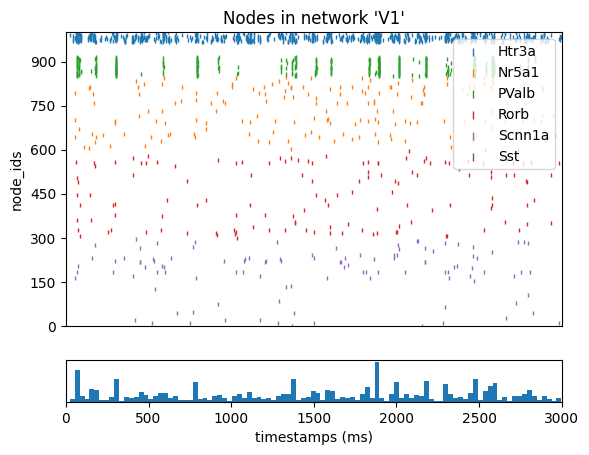

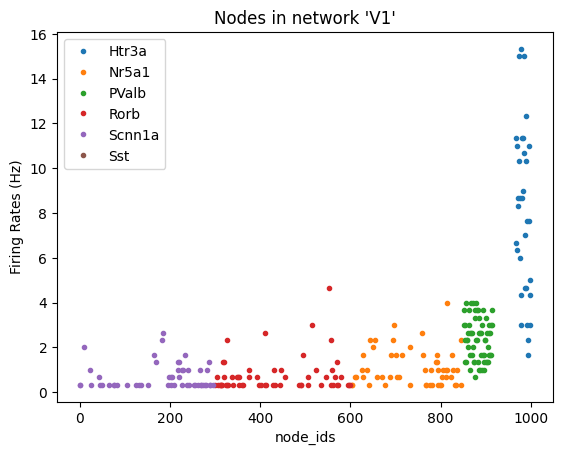

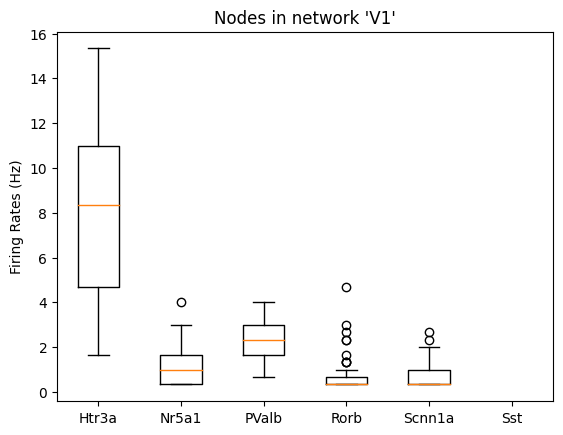

In [46]:
_ = plot_raster(config_file='config.pointnet_homework_grating_perturbation_SST.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_grating_perturbation_SST.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_grating_perturbation_SST.json', group_by='model_name')

2.4 Silence VIP neurons

In [47]:
create_environment(
        'pointnet',
        base_dir='.',
        config_file='config.pointnet_homework_grating_perturbation_VIP.json',
        network_dir='network',
        output_dir='output_pointnet_homework_grating_perturbation_VIP',
        tstop=3000.0, dt=0.1,
        report_vars=[('V1', 'V_m')],
        spikes_inputs=[('lgn', 'inputs/spikes.grating.h5')],
        run_script='run_pointnet_homework_grating_perturbation_VIP.py',
        overwrite=True,
    )

In [ ]:
'''
"inputs": {
    "lgn_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "$BASE_DIR/inputs/spikes.grating.h5",
      "node_set": "lgn"
    },
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "ei_type": "i",
        "model_name": "Htr3a"
      },
      "amp": -230.0,
      "delay": 1.0,
      "duration": 3000.0
    }
  },
'''

In [48]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet_homework_grating_perturbation_VIP.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2024-04-03 20:00:30,359 [INFO] Created log file


INFO:NestIOUtils:Created log file


2024-04-03 20:00:30,379 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2024-04-03 20:00:30,401 [INFO] Batch processing nodes for V1/0.


INFO:NestIOUtils:Batch processing nodes for V1/0.


2024-04-03 20:00:30,725 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2024-04-03 20:00:30,728 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2024-04-03 20:00:30,759 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2024-04-03 20:00:34,497 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2024-04-03 20:00:34,630 [INFO] Network created.


INFO:NestIOUtils:Network created.


2024-04-03 20:00:34,841 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2024-04-03 20:01:47,583 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2024-04-03 20:02:04,877 [INFO] Done.


INFO:NestIOUtils:Done.


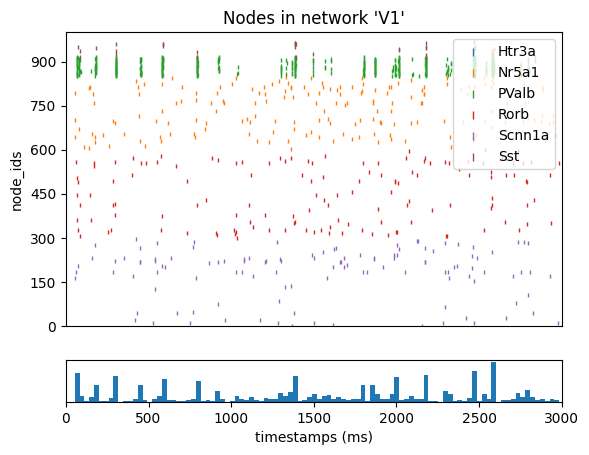

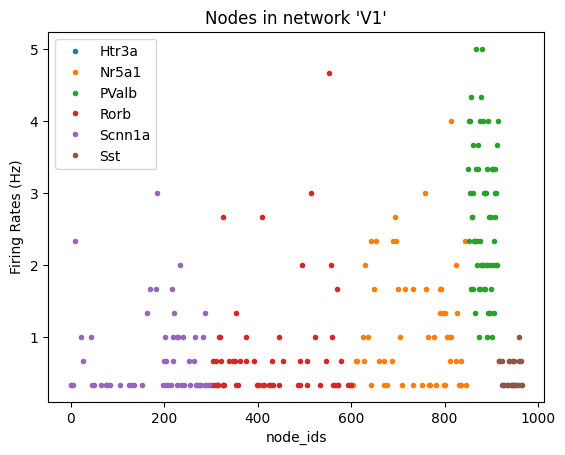

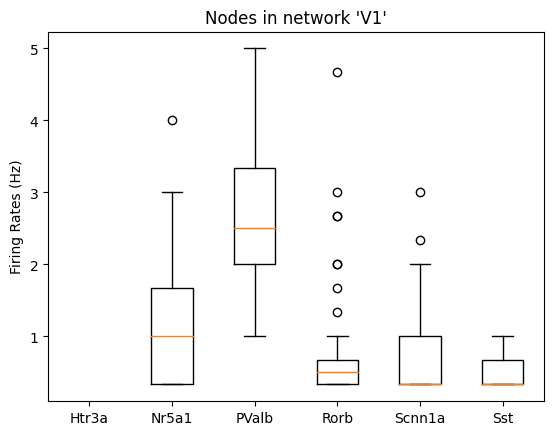

In [49]:
_ = plot_raster(config_file='config.pointnet_homework_grating_perturbation_VIP.json', group_by='model_name', show=False)
_ = plot_rates(config_file='config.pointnet_homework_grating_perturbation_VIP.json', group_by='model_name')
_ = plot_rates_boxplot(config_file='config.pointnet_homework_grating_perturbation_VIP.json', group_by='model_name')